In [1]:
import sys
sys.path.append("..")
import bqt
from bqt import bqt as bqt_dev
import time
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

/Users/pelit/.pyenv/versions/3.9.16/envs/bqtpolars2/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Introduction
The purpose of this notebook is to explore different ways for retrieving data from BigQuery using Pandas and Polars libraries. 
We introduce in bqt a new attribute called `result_format` that can take one of the following values:

* `pandas` (existing logic), calls `job.result()`, loops over rows to show progress bar and then loads to a `pandas.DataFrame`.
* `pandas simple` (new): calls directly `job.to_dataframe()`, preserving the progress bar.
* `polars` (new): calls `job.result()`, loads to pyarrow Table and then loads to a `polars.DataFrame`.

We answer the following questions:
1. How long it takes to download results from BigQuery for each `result_format` using bqt.query API call?
2. How do different formats handle nested and unnested schemas?
3. Check how local and remote caches can handle switches in formats.
4. Verify new argument works for bqt magic
5. Verify everything is working well for fast-query


📍 Since bqt 1.0.1 `pandas-simple` has replaced `pandas` result-format.

### Helpful Utils

In [20]:
def fetch_yesterday_date():
    current_date = datetime.now()
    yesterday_date = current_date - timedelta(days=1)
    return yesterday_date.strftime("%Y%m%d")

PARTITION = fetch_yesterday_date()
print(f"Query data for {PARTITION}")

Query data for 20231123


In [22]:
query_base = """
select 
stream_id,
user_id,
stream_source,
application.*,
content.*,
device.*,
feature_specifics.*,
play_context.*,
playback.*,
timestamps.*,
user_behavior.*,
user_info.*,
is_financial_stream
from `stream-pipelines.stream_days_v1.stream_days_v1_{partition}`
limit {n_rows}
"""

In [39]:
query_base_nested = """
select *
from `stream-pipelines.stream_days_v1.stream_days_v1_{partition}`
limit {n_rows}
"""

### Download with different result formats using bqt.query

Here we explore for different number of rows, the duration it takes to download results using the following result extraction logics and the bqt.query API call:

In [3]:
def get_avg_duration(query_str, method):
    durations = []
    for _ in range(10):
        start_time = time.time()
        _ = bqt_dev.query(query_str, result_format=method, cache=None)
        durations.append(time.time() - start_time)
    return np.mean(durations)


def compare_methods(query_base, n_rows):
    query_str = query_base.format(partition=PARTITION, n_rows=n_rows)
    methods = ["polars", "pandas", "pandas simple"]
    durations = dict()
    for method in methods:
        avg_duration = get_avg_duration(query_str, method)
        durations[method] = avg_duration
    durations["n_rows"] = n_rows
    return durations

In [51]:
%%capture
durations_df = pd.DataFrame([
compare_methods(query_base, 10),
compare_methods(query_base, 1_000),
compare_methods(query_base, 10_000),
compare_methods(query_base, 100_000),
])

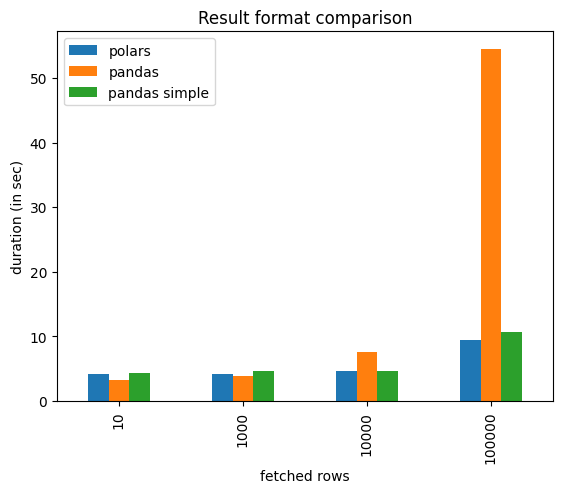

In [52]:
durations_df.set_index('n_rows').plot(kind='bar', ylabel="duration (in sec)", xlabel="fetched rows", title="Result format comparison");

In [53]:
durations_df

,polars,pandas,pandas simple,n_rows
0,4.234369,3.250474,4.275897,10
1,4.250448,3.898160,4.654466,1000
2,4.599825,7.647649,4.654985,10000
3,9.464672,54.449183,10.621090,100000


#### New pandas result extraction with progress bar

In [54]:
start_time = time.time()
pandas_df_simple = bqt_dev.query(query_base.format(partition=PARTITION, n_rows=10), result_format="pandas simple", cache=None)
print(time.time() - start_time)

Query done! Processed: 0.0 Billed: 0.0 Cost: $0.00
Job ID 5b4b7526-9787-48e1-9c38-ce035458da9d successfully executed: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
Finished downloading results
25.350441932678223


### Schema Exploration using bqt.query

In this section, we explore how pandas and polars extract the BQ schema from the query job.

**TL;DR**:

* Pandas preserves nested column structure as dictionary but polars needs the `unnested` command.

In [27]:
query_str = query_base_nested.format(partition=PARTITION, n_rows=3)

In [28]:
# nested structure is preserved
df = bqt_dev.query(query_str, result_format="pandas", cache=None)
df[['stream_source', 'application']]

Query done! Processed: 365.1 M Billed: 366.0 M Cost: $0.00
Job ID 2548bdc3-4626-4646-8545-02e40af17f4f successfully executed: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
Finished downloading results


,stream_source,application
0,end_song,{'client_id': 'd7df0887fb71494ea994202cb473eae...
1,end_song,{'client_id': 'd7df0887fb71494ea994202cb473eae...
2,end_song,{'client_id': 'd7df0887fb71494ea994202cb473eae...


In [38]:
# nested structure is preserved
df = bqt_dev.query(query_str, result_format="pandas simple", cache=None)
df[['stream_source', 'application']]

Query done! Processed: 0.0 Billed: 0.0 Cost: $0.00
Job ID 4525a24b-e646-49da-9755-d25566855b57 successfully executed: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
Finished downloading results


,stream_source,application
0,end_song,{'client_id': '2ee41864a08c418cbe81203d03fea0a...
1,end_song,{'client_id': '5342ad44959046b9aa19c537108abed...
2,end_song,{'client_id': '5342ad44959046b9aa19c537108abed...


In [29]:
# nested structure is lost for `struct` columns
df = bqt_dev.query(query_str, result_format="polars", cache=None)
df[['stream_source', 'application']]

Query done! Processed: 0.0 Billed: 0.0 Cost: $0.00
Finished downloading results


stream_source,application
str,struct[5]
"""end_song""","{""d7df0887fb71494ea994202cb473eae7"",""1.0.0"",""cloud_playback"",null,""main""}"
"""end_song""","{""d7df0887fb71494ea994202cb473eae7"",""1.0.0"",""cloud_playback"",null,""main""}"
"""end_song""","{""d7df0887fb71494ea994202cb473eae7"",""1.0.0"",""cloud_playback"",null,""main""}"


In [30]:
# expand nested columns
df.unnest("application")

stream_id,user_id,stream_source,client_id,version,build_product,build_sub_product,experience,content,device,feature_specifics,play_context,playback,timestamps,user_behavior,user_info,is_financial_stream
str,str,str,str,str,str,str,str,struct[5],struct[6],struct[1],struct[13],struct[13],struct[7],struct[13],struct[2],bool
"""70aa86b1987ca4…","""0000c2e26d8a41…","""end_song""","""d7df0887fb7149…","""1.0.0""","""cloud_playback…",null,"""main""","{""music"",""audio"",null,""spotify:track:4mYSL3RDHto3rcl7I57ndv"",false}","{""google"",""chromecast"",""cast"",null,""tv"",""Mozilla/5.0 (X11; Linux armv7l) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.225 Safari/537.36 CrKey/1.56.500000 DeviceType/Chromecast""}",{null},"{""spotify:collection"",null,null,null,false,false,null,null,""context"",null,""user_collection"",""track"",""unknown""}","{""Unknown"",194160,194160,null,null,""79936abfdaabf610361ef03483828568"",null,false,""none"",null,null,null,null}","{1700756992017,true,""Europe/Brussels"",null,null,1700756992017,""evening""}","{""home"",null,null,false,false,false,false,null,""trackdone"",""trackdone"",""unknown"",""unknown"",null}","{""BE"",true}",true
"""9364e7b983eb1c…","""0000c2e26d8a41…","""end_song""","""d7df0887fb7149…","""1.0.0""","""cloud_playback…",null,"""main""","{""music"",""audio"",null,""spotify:track:2rpbU67Z8u8D21wdP9ObRU"",false}","{""google"",""chromecast"",""cast"",null,""tv"",""Mozilla/5.0 (X11; Linux armv7l) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.225 Safari/537.36 CrKey/1.56.500000 DeviceType/Chromecast""}",{null},"{""spotify:collection"",null,null,null,false,false,null,null,""context"",null,""user_collection"",""track"",""unknown""}","{""Unknown"",143534,143534,null,null,""fdec49c0a4d6807a6d8e5398f96ac8f7"",null,false,""none"",null,null,null,null}","{1700756023859,true,""Europe/Brussels"",null,null,1700756023859,""evening""}","{""home"",null,null,false,false,false,false,null,""trackdone"",""trackdone"",""unknown"",""unknown"",null}","{""BE"",true}",true
"""f3947aadca66bc…","""0000c2e26d8a41…","""end_song""","""d7df0887fb7149…","""1.0.0""","""cloud_playback…",null,"""main""","{""music"",""audio"",null,""spotify:track:6wLc04jYNATdY8XoVys7d4"",false}","{""google"",""chromecast"",""cast"",null,""tv"",""Mozilla/5.0 (X11; Linux armv7l) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.225 Safari/537.36 CrKey/1.56.500000 DeviceType/Chromecast""}",{null},"{""spotify:collection"",null,null,null,false,false,null,null,""queue"",null,""play_queue"",null,""unknown""}","{""Unknown"",151349,151349,null,null,""7b4aae9414d9246717cb57c3826daa18"",null,false,""none"",null,null,null,null}","{1700755596413,true,""Europe/Brussels"",null,null,1700755596413,""evening""}","{""home"",null,null,false,false,false,false,null,""trackdone"",""trackdone"",""unknown"",""unknown"",null}","{""BE"",true}",true


### Cache Exploration

In this section, we explore how cache works for different result formats. 

**TL;DR**: 
* local cache is bound to one `result format` at a time: a cached polars query will need to run a new query in BQ if needed in pandas.
* remote cache is format agnostic: a BQ-cached polars query, can also be fetched as pandas without re-running the query.

#### Check Local Cache

In [ ]:
query_local_cache = query_base.format(partition=PARTITION, n_rows=8)

In [31]:
# cache gets created

df = bqt_dev.query(query_local_cache, result_format="polars", cache="local")
type(df)

Query done! Processed: 300.1 M Billed: 300.9 M Cost: $0.00
Finished downloading results


polars.dataframe.frame.DataFrame

In [32]:
# cache works

df = bqt_dev.query(query_local_cache, result_format="polars", cache="local")
type(df)

Found cached data that is 29 second(s) old, using it.


polars.dataframe.frame.DataFrame

In [33]:
# !!! cache will NOT work: local data is in polars, pandas will make a new BQ query

df = bqt_dev.query(query_local_cache, result_format="pandas", cache="local")
type(df)

Query done! Processed: 0.0 Billed: 0.0 Cost: $0.00
Finished downloading results


pandas.core.frame.DataFrame

#### Check Remote Cache

In [ ]:
query_remote_cache = query_base.format(partition=PARTITION, n_rows=10)

In [27]:
bqt_dev.change_project("playx-insights")
bqt_dev.set_config({
    "cache.bq.project": "playx-insights",
    "cache.bq.dataset": "adhoc",
    "cache.bq.table_prefix": "test_bqt_1_",
})
df = bqt_dev.query(query_remote_cache, result_format="polars", cache="bq")
type(df)

Running job playx-insights:6df0c8c0-d015-4129-b31a-750d99697c56
Query done! Processed: 304.2 M Billed: 305.1 M Cost: $0.00
Finished downloading results


polars.dataframe.frame.DataFrame

In [29]:
# rerun to fetch remote cache
df = bqt_dev.query(query_remote_cache, result_format="polars", cache="bq")
type(df)

Found cached data that is 51 second(s) old, using it.
Query done! Processed: 0.0 Billed: 0.0 Cost: $0.00
Finished downloading results


polars.dataframe.frame.DataFrame

In [30]:
# data still cached in bQ but now we can fetch them using pandas
df = bqt_dev.query(query_remote_cache, result_format="pandas", cache="bq")
type(df)

Found cached data that is 1 minute(s) 22 second(s) old, using it.
Query done! Processed: 0.0 Billed: 0.0 Cost: $0.00
Finished downloading results


pandas.core.frame.DataFrame

### Enhance bqt magic

BQT cell magic is now be extended to contain all arguments available in `bqt.query` command. Below we see an example with the newly-introduced `results_format` argument.

In [32]:
%load_ext bqt.bqt_extension

In [36]:
%%bqt --result_format polars

select 
stream_id,
user_id,
stream_source,
application.*,
content.*,
device.*,
feature_specifics.*,
play_context.*,
playback.*,
timestamps.*,
user_behavior.*,
user_info.*,
is_financial_stream
from `stream-pipelines.stream_days_v1.stream_days_v1_{LATEST}`
limit 3

LATEST: using `stream-pipelines.stream_days_v1.stream_days_v1_20231123`
Query done! Processed: 334.9 M Billed: 335.5 M Cost: $0.00
Finished downloading results


stream_id,user_id,stream_source,client_id,version,build_product,build_sub_product,experience,content_type,media_type,display_uri,uri,is_preview,brand,model,os,os_version,device_type,user_agent,custom_reporting_attribution,anonymized_play_context_uri,content_id,content_name,is_algotorial,is_enhanced,is_programmed,playlist_owner_id,playlist_owner_type,provider_top_type,provider_sub_type,top_type,sub_type,uri_type,audio_format,ms_nominal_played,ms_played,ms_played_background,parent_playback_id,playback_id,ms_played_overlapped,is_downloaded,streaming_rule,ms_narration_overlapping,experience_type,ms_trimmed,ms_nominal_trimmed,default_timestamp,derived_from_receive_timestamp,location_timezone,playback_end_timestamp_estimate,playback_start_timestamp_estimate,receive_timestamp,daypart,referrer_root,interaction_id,is_connect,is_incognito,is_offline,is_shuffle,is_skipped,page_instance_id,reason_end,reason_start,source_end,source_start,decision_id,connection_country,is_premium,is_financial_stream
str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,str,str,str,str,bool,bool,bool,str,str,str,str,str,str,str,str,i64,i64,i64,str,str,i64,bool,str,i64,str,i64,i64,i64,bool,str,i64,i64,i64,str,str,str,bool,bool,bool,bool,bool,str,str,str,str,str,str,str,bool,bool
"""7caa0266955ef0…","""0016969a296f4e…","""end_song""","""34ff3710281c4c…","""3.201.448""","""esdk""","""esdk_v3""","""main""","""music""","""audio""",null,"""spotify:track:…",false,null,null,"""unknown""",null,"""unknown""","""63504832""",null,"""spotify:playli…","""5ZuhQEVnXYVXyZ…",null,false,false,false,"""6895a7bc698141…","""other_user""","""context""",null,"""user_playlist""",null,"""playlist""","""Unknown""",208266,208266,null,null,"""82a07ef4a51410…",null,false,"""none""",null,null,null,null,1700780890675,true,"""Europe/Berlin""",null,null,1700780890675,"""late_evening""",null,null,null,false,false,true,false,null,"""trackdone""","""trackdone""",null,null,null,"""DE""",true,true
"""b3aad06c454da7…","""0016969a296f4e…","""end_song""","""34ff3710281c4c…","""3.201.448""","""esdk""","""esdk_v3""","""main""","""music""","""audio""",null,"""spotify:track:…",false,null,null,"""unknown""",null,"""unknown""","""63504832""",null,"""spotify:playli…","""5ZuhQEVnXYVXyZ…",null,false,false,false,"""6895a7bc698141…","""other_user""","""context""",null,"""user_playlist""",null,"""playlist""","""Unknown""",398744,398744,null,null,"""8d5120cf9f7ed2…",null,false,"""none""",null,null,null,null,1700778691939,true,"""Europe/Berlin""",null,null,1700778691939,"""late_evening""",null,null,null,false,false,true,false,null,"""trackdone""","""trackdone""",null,null,null,"""DE""",true,true
"""cc8d28a0a05cd2…","""0016969a296f4e…","""end_song""","""34ff3710281c4c…","""3.201.448""","""esdk""","""esdk_v3""","""main""","""music""","""audio""",null,"""spotify:track:…",false,null,null,"""unknown""",null,"""unknown""","""63504832""",null,"""spotify:playli…","""5ZuhQEVnXYVXyZ…",null,false,false,false,"""6895a7bc698141…","""other_user""","""context""",null,"""user_playlist""",null,"""playlist""","""Unknown""",170341,170341,null,null,"""1d105a7c04fe36…",null,false,"""none""",null,null,null,null,1700782477996,true,"""Europe/Berlin""",null,null,1700782477996,"""late_evening""",null,null,null,false,false,true,false,null,"""trackdone""","""trackdone""",null,null,null,"""DE""",true,true


In [37]:
type(temp)

polars.dataframe.frame.DataFrame

### Fast Query

In [43]:
query_nested = query_base_nested.format(partition=PARTITION, n_rows=4)

In [44]:
# initialize local cache
df = bqt_dev.fast_query(query_nested, result_format="polars")
print(type(df))
df.head(3)

Attempting dry-run before executing full query...
<IPython.core.display.HTML object>
DRY RUN: Would Process: 8847.5 G Would Cost: $40.23
Nested or repeated results, enabling experimental advanced_dtype_handling flag.
Staging bucket: gs://fastbqt-staging-eu-playx-insights
Job playx-insights:332de182-1a87-431b-9a72-f09792f8d14c submitted ...
Job finished successfully!
Got 4 rows (0.0)
Compressing and preparing files ...
1 chunks (6.9 K) will be downloaded!
Time elapsed: 0:00:03.384210
<class 'polars.dataframe.frame.DataFrame'>


stream_id,user_id,stream_source,application,content,device,feature_specifics,play_context,playback,timestamps,user_behavior,user_info,is_financial_stream
str,str,str,struct[5],struct[5],struct[6],struct[1],struct[13],struct[13],struct[7],struct[13],struct[2],bool
"""70aa86b1987ca4…","""0000c2e26d8a41…","""end_song""","{""d7df0887fb71494ea994202cb473eae7"",""1.0.0"",""cloud_playback"",null,""main""}","{""music"",""audio"",null,""spotify:track:4mYSL3RDHto3rcl7I57ndv"",false}","{""google"",""chromecast"",""cast"",null,""tv"",""Mozilla/5.0 (X11; Linux armv7l) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.225 Safari/537.36 CrKey/1.56.500000 DeviceType/Chromecast""}",{null},"{""spotify:collection"",null,null,null,false,false,null,null,""context"",null,""user_collection"",""track"",""unknown""}","{""Unknown"",194160,194160,null,null,""79936abfdaabf610361ef03483828568"",null,false,""none"",null,null,null,null}","{1700756992017,true,""Europe/Brussels"",null,null,1700756992017,""evening""}","{""home"",null,null,false,false,false,false,null,""trackdone"",""trackdone"",""unknown"",""unknown"",null}","{""BE"",true}",true
"""9364e7b983eb1c…","""0000c2e26d8a41…","""end_song""","{""d7df0887fb71494ea994202cb473eae7"",""1.0.0"",""cloud_playback"",null,""main""}","{""music"",""audio"",null,""spotify:track:2rpbU67Z8u8D21wdP9ObRU"",false}","{""google"",""chromecast"",""cast"",null,""tv"",""Mozilla/5.0 (X11; Linux armv7l) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.225 Safari/537.36 CrKey/1.56.500000 DeviceType/Chromecast""}",{null},"{""spotify:collection"",null,null,null,false,false,null,null,""context"",null,""user_collection"",""track"",""unknown""}","{""Unknown"",143534,143534,null,null,""fdec49c0a4d6807a6d8e5398f96ac8f7"",null,false,""none"",null,null,null,null}","{1700756023859,true,""Europe/Brussels"",null,null,1700756023859,""evening""}","{""home"",null,null,false,false,false,false,null,""trackdone"",""trackdone"",""unknown"",""unknown"",null}","{""BE"",true}",true
"""f3947aadca66bc…","""0000c2e26d8a41…","""end_song""","{""d7df0887fb71494ea994202cb473eae7"",""1.0.0"",""cloud_playback"",null,""main""}","{""music"",""audio"",null,""spotify:track:6wLc04jYNATdY8XoVys7d4"",false}","{""google"",""chromecast"",""cast"",null,""tv"",""Mozilla/5.0 (X11; Linux armv7l) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.225 Safari/537.36 CrKey/1.56.500000 DeviceType/Chromecast""}",{null},"{""spotify:collection"",null,null,null,false,false,null,null,""queue"",null,""play_queue"",null,""unknown""}","{""Unknown"",151349,151349,null,null,""7b4aae9414d9246717cb57c3826daa18"",null,false,""none"",null,null,null,null}","{1700755596413,true,""Europe/Brussels"",null,null,1700755596413,""evening""}","{""home"",null,null,false,false,false,false,null,""trackdone"",""trackdone"",""unknown"",""unknown"",null}","{""BE"",true}",true


In [45]:
# verify local cache works 
df = bqt_dev.fast_query(query_nested, result_format="polars")
print(type(df))

Found cached data that is 18 second(s) old, using it.
Time elapsed: 0:00:00.299204
<class 'polars.dataframe.frame.DataFrame'>


In [46]:
# explore pandas
df = bqt_dev.fast_query(query_nested, result_format="pandas")
print(type(df))
df.head(3)

Attempting dry-run before executing full query...
<IPython.core.display.HTML object>
DRY RUN: Would Process: 8847.5 G Would Cost: $40.23
Nested or repeated results, enabling experimental advanced_dtype_handling flag.
Staging bucket: gs://fastbqt-staging-eu-playx-insights
Job playx-insights:6b927f5a-7146-4d85-a30d-38b8b5a2b648 submitted ...
Job finished successfully!
Got 4 rows (0.0)
Compressing and preparing files ...
1 chunks (6.9 K) will be downloaded!
Time elapsed: 0:00:03.815915
<class 'pandas.core.frame.DataFrame'>


,stream_id,user_id,stream_source,application,content,device,feature_specifics,play_context,playback,timestamps,user_behavior,user_info,is_financial_stream
0,70aa86b1987ca4ebbdbf007c71c3f0e6,0000c2e26d8a4107b16645a9ab64b26c,end_song,{'client_id': 'd7df0887fb71494ea994202cb473eae...,"{'content_type': 'music', 'media_type': 'audio...","{'brand': 'google', 'model': 'chromecast', 'os...",{'custom_reporting_attribution': None},{'anonymized_play_context_uri': 'spotify:colle...,"{'audio_format': 'Unknown', 'ms_nominal_played...","{'default_timestamp': 1700756992017, 'derived_...","{'referrer_root': 'home', 'interaction_id': No...","{'connection_country': 'BE', 'is_premium': True}",True
1,9364e7b983eb1cc967122467d40907bd,0000c2e26d8a4107b16645a9ab64b26c,end_song,{'client_id': 'd7df0887fb71494ea994202cb473eae...,"{'content_type': 'music', 'media_type': 'audio...","{'brand': 'google', 'model': 'chromecast', 'os...",{'custom_reporting_attribution': None},{'anonymized_play_context_uri': 'spotify:colle...,"{'audio_format': 'Unknown', 'ms_nominal_played...","{'default_timestamp': 1700756023859, 'derived_...","{'referrer_root': 'home', 'interaction_id': No...","{'connection_country': 'BE', 'is_premium': True}",True
2,f3947aadca66bca4673c2082b7de43c7,0000c2e26d8a4107b16645a9ab64b26c,end_song,{'client_id': 'd7df0887fb71494ea994202cb473eae...,"{'content_type': 'music', 'media_type': 'audio...","{'brand': 'google', 'model': 'chromecast', 'os...",{'custom_reporting_attribution': None},{'anonymized_play_context_uri': 'spotify:colle...,"{'audio_format': 'Unknown', 'ms_nominal_played...","{'default_timestamp': 1700755596413, 'derived_...","{'referrer_root': 'home', 'interaction_id': No...","{'connection_country': 'BE', 'is_premium': True}",True
